# Learning to Rank Assignment for ESSIR'24

In this assignment you will implement pointwise, pairwise, listwise  and metric-based Learning to Rank (LTR) losses to optimize four ranking models and evaluate the differences in their performance.

# Introduction

## Package and Dataset Setup

We will start by installing the [Rax 🦖 package](https://rax.readthedocs.io/en/stable/):

In [ ]:
!pip install -q pip install rax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.9/78.9 kB 1.4 MB/s eta 0:00:00


Next, import the packages that we will use in this notebook:

In [ ]:
# usage of numpy is discouraged
import numpy as np
# tensorflow is only used for data loading and pre-processing
import tensorflow as tf
import tensorflow_datasets as tfds
# the following jax packages are used for the LTR optimization and evaluation
import jax
import jax.numpy as jnp
import flax
import optax
import rax
# the following imports make our code briefer
from flax import linen as nn
from flax.training import train_state
from functools import partial
# we will time some of the runs
import time
# and make some plots
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 3]

The following code reades in the MSLR-Web10k dataset, applies a feature transformation, and creates padded batches that enable us to quickly iterate over the data.

You do not have to understand this function, but should understand its output. We will discuss the output later.

This code can take about seven minutes to run, we advise you start it as-soon-as-possible and continue reading while it is busy.

In [ ]:
def prepare_dataset(
    ds: tf.data.Dataset,
    rng_seed: int = 42,
    max_list_size = 200,
):
  """Prepares a training dataset by applying padding/truncating/etc."""
  tf.random.set_seed(rng_seed)
  features_to_keep = set(["label", "float_features"])
  ds = ds.map(lambda e: {k: v for k, v in e.items() if k in features_to_keep})
  ds = ds.map(lambda e: (e.pop("float_features"), e.pop("label")))
  ds = ds.map(lambda x, y: (tf.sign(x)*tf.math.log1p(tf.abs(x)), 2.**y-1.))
  ds = ds.map(lambda x, y: (x, y, tf.ones_like(y, dtype=tf.bool)))

  # not every query has the same number of pre-selected documents in the dataset
  # therefore, we add padding so that the matrices can be batched together
  def pad(t):
    shape = tf.concat([tf.maximum(tf.constant([max_list_size])-tf.shape(t)[0], 0), tf.shape(t)[1:]], 0)
    return tf.concat([t, tf.zeros(shape, dtype=t.dtype)], 0)

  ds = ds.map(lambda x, y, z: (pad(x), pad(y), pad(z)))
  ds = ds.map(lambda x, y, z: (x[:max_list_size, :], y[:max_list_size], z[:max_list_size]))
  ds = ds.cache()
  ds = ds.shuffle(1000, seed=rng_seed)
  ds = ds.batch(128)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  ds = tfds.as_numpy(ds)
  return ds

train_ds = prepare_dataset(tfds.load("mslr_web/10k_fold1", split="train"))
vali_ds = prepare_dataset(tfds.load("mslr_web/10k_fold1", split="vali"))
test_ds = prepare_dataset(tfds.load("mslr_web/10k_fold1", split="test"))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/6000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mslr_web/10k_fold1/incomplete.89F9CE_1.2.0/mslr_web-train.tfrecord*...:   …

Generating vali examples...:   0%|          | 0/2000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mslr_web/10k_fold1/incomplete.89F9CE_1.2.0/mslr_web-vali.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/2000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mslr_web/10k_fold1/incomplete.89F9CE_1.2.0/mslr_web-test.tfrecord*...:   0…

Dataset mslr_web downloaded and prepared to /root/tensorflow_datasets/mslr_web/10k_fold1/1.2.0. Subsequent calls will reuse this data.


After this pre-processing, the dataset object will return batches of document-query features, relevance labels and a mask for the batch.
These have the following dimensions:
*   Features (num queries per batch, max. num of documents per query, number of features per doc./query combination)
*   Relevance labels  (num queries per batch, max. num of documents per query)
*   Mask (num queries per batch, max. num of documents per query)

### A closer look at the data


We'll start by sampling a single batch as an example.

In [ ]:
example_input, example_labels, example_mask = next(iter(train_ds))

Let's start by looking at the features of the (padded) batch.

In [ ]:
print(f'The batch of features has the shape {example_input.shape},')
print(f'thus a batch contains {example_input.shape[0]} queries, '
      f'per query a maximum of {example_input.shape[1]} documents are considered, '
      f'and each doc./query combination is represented by {example_input.shape[2]} features.')
print('Let\'s take a look at the features of the first query./doc:')
print(example_input[0,0,:])

The batch of features has the shape (128, 200, 136),
thus a batch contains 128 queries, per query a maximum of 200 documents are considered, and each doc./query combination is represented by 136 features.
Let's take a look at the features of the first query./doc:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  6.93147181e-01
  6.93147181e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  6.93147181e-01  6.93147181e-01  6.38856141e+00  0.00000000e+00
  1.09861229e+00  2.19722458e+00  6.40522846e+00  2.69913074e+00
  2.87982989e+00  2.90810623e+00  2.96633853e+00  2.69635272e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  6.93147181e-01
  6.93147181e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  6.93147181e-01  6.93147181e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  6.93147181e-01  6.93147181e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  6.93147181e-01  6.93147181e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.0

This batch is padded, if we look at the final document of the first query, it most likely returns us padded zeros (it could be that the case that we are unlucky and this query is not padded actually).

In [ ]:
example_input[0,-1,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

The following will tell us if this is *not* padded values:

In [ ]:
example_mask[0,-1]

False

Next, we'll consider the relevance labels, there is a single label for each doc./query combination. In the preprocessing the labels have already been scaled by the function:
$$\textit{new label} = 2^\textit{raw label}-1.$$

In [ ]:
print(f'The batch of relevance labels has the shape {example_labels.shape}.')
print(f'These are the labels for the first query:')
example_labels[0,:]

The batch of relevance labels has the shape (128, 200).
These are the labels for the first query:


array([ 0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,  0.,
        7.,  1.,  1.,  0.,  7.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,
        1.,  1.,  0.,  1.,  0.,  3.,  0.,  1.,  1.,  1.,  0.,  0.,  1.,
        1.,  1.,  0.,  1.,  0.,  3.,  0.,  1.,  1.,  1.,  1.,  3.,  1.,
        1.,  1.,  1.,  0., 15.,  1.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,
        1.,  1., 15.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,
        3.,  3.,  1.,  0.,  1.,  7.,  1.,  1.,  1.,  1.,  1.,  3.,  1.,
        1.,  7.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,
        1.,  7.,  0.,  0.,  1.,  0., 15.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

However, not all labels are part of the data because batches are padded.
The masks indicate which documents are part of the dataset and which are padded zeros. Let's look at the mask for the first query:

In [ ]:
print(f'The batch mask has the shape {example_labels.shape}, one value for each doc./query combination.')
print(f'The mask for the first query:')
example_mask[0,:]

The batch mask has the shape (128, 200), one value for each doc./query combination.
The mask for the first query:


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

By summming the mask over the last axis, we can see how many documents are available per query:

In [ ]:
jnp.sum(example_mask, axis=-1)

Array([112, 109, 125,  60,   9,  76,  70, 134, 140, 140, 161,   4, 129,
       200, 200, 109, 198,  56, 111, 181, 153, 143,  77,  17,  69, 190,
        63,  46, 181,  75,  15,  42,  91,  26, 200, 131, 163,  18, 136,
        76, 129, 131,  87, 102, 111,  39, 122, 158, 106, 200, 110, 147,
        98, 195,  22,  91,  60,  95, 200,  48, 136, 131,  82, 124,  26,
       162, 200, 112,  93, 120,  48, 104,  99,  79, 200, 152, 145, 125,
       120,  44,  68, 126, 158,  67,  88,  60,  77,  34,  91,  70, 170,
       177, 200, 148, 152, 117, 163,  56,  87, 157, 130,  70, 200,  11,
       101,  92,  63,  62,  96,  87, 200, 178,  68, 107, 192,  95,  99,
       101, 132, 200, 124, 156, 154,  72, 134,  81,  46, 170],      dtype=int32)

If we apply the first mask to the first vector of relevance labels, we only get the labels and none of the padding:

In [ ]:
example_labels[0,:][example_mask[0,:]]

array([ 0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,  0.,
        7.,  1.,  1.,  0.,  7.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,
        1.,  1.,  0.,  1.,  0.,  3.,  0.,  1.,  1.,  1.,  0.,  0.,  1.,
        1.,  1.,  0.,  1.,  0.,  3.,  0.,  1.,  1.,  1.,  1.,  3.,  1.,
        1.,  1.,  1.,  0., 15.,  1.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,
        1.,  1., 15.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,
        3.,  3.,  1.,  0.,  1.,  7.,  1.,  1.,  1.,  1.,  1.,  3.,  1.,
        1.,  7.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,
        1.,  7.,  0.,  0.,  1.,  0., 15.,  1.])

A neat thing we can do with jnp.sum and jnp.mean is use the where flag to indicate what values to ignore. For example, we can compute the mean label per query while ignoring the padding like this:

In [ ]:
jnp.mean(example_labels, axis=-1, where=example_mask)

Array([1.3839285 , 0.74311924, 0.216     , 0.8       , 0.44444445,
       1.1184211 , 0.15714286, 0.5       , 0.94285715, 0.6785714 ,
       0.9875776 , 0.        , 0.7751938 , 0.025     , 0.19      ,
       1.3394495 , 1.0555556 , 0.44642857, 0.7567568 , 1.5248619 ,
       0.503268  , 1.6083916 , 2.090909  , 0.1764706 , 0.02898551,
       0.7368421 , 0.11111111, 0.26086956, 0.17679559, 0.8933333 ,
       0.4       , 0.        , 0.6813187 , 0.5       , 0.54      ,
       0.9236641 , 1.01227   , 0.44444445, 0.9558824 , 1.6447369 ,
       1.3100775 , 0.8549618 , 1.3678161 , 0.5980392 , 1.063063  ,
       0.23076923, 0.8852459 , 1.3037975 , 1.745283  , 0.805     ,
       1.9090909 , 1.0544218 , 1.6224489 , 0.14358975, 0.36363637,
       0.43956044, 0.51666665, 0.17894737, 0.665     , 0.20833333,
       1.4632353 , 2.648855  , 0.25609756, 1.0080645 , 0.6923077 ,
       0.5123457 , 0.575     , 0.70535713, 1.8172044 , 0.56666666,
       0.45833334, 1.3365384 , 0.97979796, 0.21518987, 0.395  

## Defining the Model to Optimize and Evaluation
We will use a simple two layer networks to optimize with our ranking losses. Using the flax package we define:

In [ ]:
class SimpleModel(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=64)(x)
        x = nn.sigmoid(x)
        x = nn.Dense(features=64)(x)
        x = nn.sigmoid(x)
        x = nn.Dense(features=1)(x)
        return jnp.squeeze(x, axis=-1)

The following code initializes an instance of this model and predicts scores for the example input.

In [ ]:
# this a random-number-generator key, every random operation needs unique key in jax
rng = jax.random.key(42)
# we create a new key for the random initialization of our model
rng, init_rng = jax.random.split(rng)
# using the key we initialize the model
model = SimpleModel()
params = model.init(init_rng, example_input)
# note that we explicitly keep track of the parameters
# we apply the model to the example batch
example_scores = model.apply(params, example_input)
print(f'The following array has the following shape: {example_scores.shape}.')
example_scores

The following array has the following shape: (128, 200).


Array([[-0.34756666, -0.3148062 , -0.20859158, ..., -0.26162535,
        -0.26162535, -0.26162535],
       [-0.26272762, -0.30364105, -0.3160178 , ..., -0.26162535,
        -0.26162535, -0.26162535],
       [-0.2017543 , -0.18255858, -0.19882233, ..., -0.26162535,
        -0.26162535, -0.26162535],
       ...,
       [-0.17223729, -0.15902287, -0.14893435, ..., -0.26162535,
        -0.26162535, -0.26162535],
       [-0.13955577, -0.18073328, -0.19709086, ..., -0.26162535,
        -0.26162535, -0.26162535],
       [-0.23197801, -0.20048068, -0.15147252, ..., -0.26162535,
        -0.26162535, -0.26162535]], dtype=float32)

Obviously, these scores make little sense since the model has not been optimized. Nevertheless, using the rax package we can evaluate the NDCG per query:

In [ ]:
# the randomization is used to randomly break possible score ties
rng, eval_rng = jax.random.split(rng)
rax.ndcg_metric(example_scores, example_labels, where=example_mask,
                key=eval_rng, reduce_fn=None, topn=10)

Array([9.0055928e-06, 1.0972063e-03, 3.1271324e-02, 5.7189894e-01,
       7.3277116e-01, 4.1434309e-01, 1.8602811e-01, 4.2785970e-03,
       1.5884850e-04, 1.0731942e-01, 2.1218937e-03, 0.0000000e+00,
       1.2726989e-01, 1.0699313e-01, 1.6598910e-01, 3.1318825e-01,
       2.7238038e-05, 0.0000000e+00, 8.3549144e-03, 3.5750642e-02,
       2.0943418e-05, 5.0423093e-02, 1.4162067e-03, 1.4126699e-01,
       1.9342642e-01, 2.4806826e-01, 8.6713836e-02, 6.5241985e-02,
       0.0000000e+00, 8.8166153e-06, 5.0126588e-01, 0.0000000e+00,
       5.6318354e-06, 6.2562692e-01, 4.3294854e-03, 2.3483783e-02,
       2.4007437e-05, 5.0765133e-01, 1.0939437e-01, 1.5322648e-01,
       3.3761826e-05, 6.4549424e-02, 1.1841159e-05, 2.5544721e-01,
       3.7300128e-01, 4.2772341e-01, 4.1788067e-03, 2.3544582e-02,
       2.2664008e-01, 2.6019892e-02, 3.0757676e-04, 2.4478496e-03,
       2.5197524e-03, 0.0000000e+00, 5.8780980e-01, 0.0000000e+00,
       2.6345047e-01, 4.2464726e-02, 9.0613496e-03, 2.7211653e

Or the mean NDCG of the batch:

In [ ]:
rng, eval_rng = jax.random.split(rng)
rax.ndcg_metric(example_scores, example_labels, where=example_mask,
                key=eval_rng, topn=10)

Array(0.10333021, dtype=float32)

## Optimizing an Example Loss Function
You will only have to implement the loss functions that define each learning-to-rank method, we provide you with the following code for optimization.

In [ ]:
@partial(jax.jit, static_argnames=['loss_fn'])
def train_step(state, query, loss_fn):

    @jax.jit
    def calculate_loss(state, params, query):
        feat, labels, mask = query
        scores = state.apply_fn(params, feat)
        return jnp.mean(jax.vmap(loss_fn)(scores, labels, mask))

    loss, grads = jax.value_and_grad(calculate_loss, argnums=1)(state, state.params, query)
    state = state.apply_gradients(grads=grads)
    return state, loss

@jax.jit
def ndcg_for_batch(state, query, key=None):
    feat, labels, mask = query
    scores = state.apply_fn(state.params, feat)
    return rax.ndcg_metric(scores, labels, topn=10, where=mask, key=key)

def dataset_ndcg(ds, state, rng):
  metric_sum = 0.
  counter = 0.
  for query in ds:
    rng, eval_rng = jax.random.split(rng)
    metric_sum += ndcg_for_batch(state, query, key=eval_rng)
    counter += 1
  return metric_sum/counter

def optimize_loss(loss_fn, rng, max_epochs, learning_rate=0.01, evaluate_every=10, verbose=True):
  rng, init_rng, eval_rng = jax.random.split(rng, 3)
  model = SimpleModel()
  params = model.init(init_rng, example_input)
  optimizer = optax.adamax(learning_rate=learning_rate)
  model_state = train_state.TrainState.create(apply_fn=model.apply,
                                              params=params,
                                              tx=optimizer)
  performance = dataset_ndcg(vali_ds, model_state, eval_rng)
  output_list = []
  for epoch_i in range(max_epochs):
    loss_sum = 0.
    counter = 0.
    for query in train_ds:
      model_state, loss = train_step(model_state, query, loss_fn)
      loss_sum += loss
      counter += 1
      if epoch_i == 0 and counter == 1:
        # the first loss in the list is only based on the first batch
        if verbose:
          print(f'Epoch: 0, Loss: {loss:.3f}, NDCG: {performance:.3f}')
        output_list.append((0, loss, performance))
    if (epoch_i+1) % evaluate_every == 0:
      rng, eval_rng = jax.random.split(rng)
      performance = dataset_ndcg(vali_ds, model_state, eval_rng)
      output_list.append((epoch_i+1, loss_sum/counter, performance))
      if verbose:
        print(f'Epoch: {epoch_i+1}, Loss: {loss_sum/counter:.3f}, NDCG: {performance:.4f}')
    else:
      output_list.append((epoch_i+1, loss_sum/counter))
  return output_list

The *optimize_loss* function requires a loss function (*loss_fn*) that takes as input a vector of scores, a vector of labels and a masking vector. Importantly, this function should work with [jit compilation](https://jax.readthedocs.io/en/latest/jit-compilation.html) in jax, this means we have to avoid basic Python control-flow operations like *if* statements, *for* and *while* loops, etc. and limit ourselfs to jax.numpy operations.
All the loss functions in this assignment are simple to implement with only such operations.

As an example, we will show you how we can implement and optimize a very simple but nonsensical loss:
$$L = \sum_{d}\hat{y}_d(y_d-1)$$
Here $D$ is the set of documents (pre-selected for a single query) and $\hat{y}_d$ is the predicted score for document $d$ whereas $y_d$ is the true label.
This loss function does not make a lot of sense, but it will push documents with higher labels to get higher scores.

Regardless, we can optimize this loss with the following code, that should finish 10 epochs in less than 90 seconds:

In [ ]:
def example_loss_fn(scores, labels, mask):
  return -jnp.sum(scores*(labels-1), where=mask)

rng, optimize_rng = jax.random.split(rng)
example_output = optimize_loss(example_loss_fn, optimize_rng, max_epochs=4, evaluate_every=1)

Epoch: 0, Loss: 1.774, NDCG: 0.077
Epoch: 1, Loss: -156.105, NDCG: 0.2342
Epoch: 2, Loss: -620.121, NDCG: 0.2486
Epoch: 3, Loss: -1128.566, NDCG: 0.2588
Epoch: 4, Loss: -1649.459, NDCG: 0.2690


We will use the following code to visualize the optimization of different losses:

In [ ]:
def visualize_output(output_list, title=None):
  if title:
    plt.title(title + ' - Loss Progression')
  else:
    plt.title('Example Loss progression')
  plt.plot([x[0] for x in output_list if len(x) > 1],
          [x[1] for x in output_list if len(x) > 1])
  plt.xlabel('Number of Epochs')
  plt.ylabel('Loss Value')
  plt.show()
  plt.close()
  if title:
    plt.title(title + ' - Performance Progression')
  else:
    plt.title('Example Performance progression')
  plt.plot([x[0] for x in output_list if len(x) > 2],
          [x[2] for x in output_list if len(x) > 2])
  plt.xlabel('Number of Epochs')
  plt.ylabel('NDCG@10')
  plt.show()
  plt.close()

Let's take a look at the learning curves for our example nonsense loss:

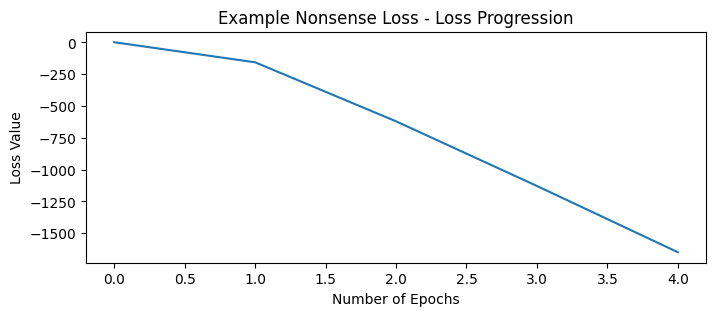

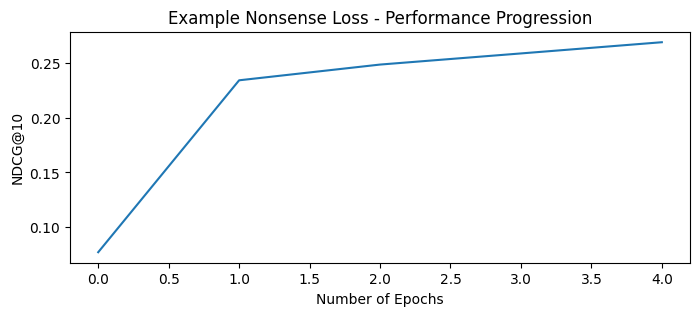

In [ ]:
visualize_output(example_output, title='Example Nonsense Loss')

While it does work, we can do much better. It is now up to you to implement real LTR loss functions to outperform this nonsense.

# 1 Pointwise Learning to Rank

There first loss to implement is the **pointwise** [Mean-Squared-Error](https://en.wikipedia.org/wiki/Mean_squared_error) (MSE) regression loss:
$$L = \frac{1}{D} \sum_{d}(\hat{y}_d - y_d)^2.$$
Here $D$ is the set of documents (pre-selected for a single query) and $\hat{y}_d$ is the predicted score for document $d$ whereas $y_d$ is the true label.

Complete the function below so that it provides the pointwise MSE loss, such that it can be used by jax for gradient calculation and jit-compilation. (Avoid if statements and for/while loops, use functions from [jax.numpy](https://jax.readthedocs.io/en/latest/jax.numpy.html), imported as jnp.)

In [ ]:
def MSE_loss_fn(scores, labels, mask):
#   return jnp.mean(scores, where=mask)
  return jnp.mean((scores - labels)**2, where=mask)

The assertions below will test whether your implementation returns the correct loss values in some scenarios:

In [ ]:
# checks without masking
assert jnp.isclose(MSE_loss_fn(jnp.array([0.,0.]), jnp.array([0.,0.]), jnp.array([True,True])), 0)
assert jnp.isclose(MSE_loss_fn(jnp.array([1.,0.]), jnp.array([0.,1.]), jnp.array([True,True])), 1)
assert jnp.isclose(MSE_loss_fn(jnp.array([2.,-2.]), jnp.array([0.,1.]), jnp.array([True,True])), 6.5)
assert jnp.isclose(MSE_loss_fn(jnp.array([2.5,-0.2]), jnp.array([0.,1.]), jnp.array([True,True])), 3.845)
assert jnp.isclose(MSE_loss_fn(jnp.array([2.5,-0.2]), jnp.array([1.,0.]), jnp.array([True,True])), 1.145)
# checks with masking
assert jnp.isclose(MSE_loss_fn(jnp.array([0.,0.,1]), jnp.array([0.,0.,0]), jnp.array([True,True,False])), 0)
assert jnp.isclose(MSE_loss_fn(jnp.array([1.,0.,1]), jnp.array([0.,1.,0]), jnp.array([True,True,False])), 1)
assert jnp.isclose(MSE_loss_fn(jnp.array([2.,-2.,1]), jnp.array([0.,1.,0]), jnp.array([True,True,False])), 6.5)
assert jnp.isclose(MSE_loss_fn(jnp.array([2.5,-0.2,1]), jnp.array([0.,1.,0]), jnp.array([True,True,False])), 3.845)
assert jnp.isclose(MSE_loss_fn(jnp.array([2.5,-0.2,1]), jnp.array([1.,0.,0]), jnp.array([True,True,False])), 1.145)

Next, we will test whether your code works with jit compilation, and test how quickly we can run one epoch:

In [ ]:
start_time = time.time()
optimize_loss(MSE_loss_fn, optimize_rng, max_epochs=1, evaluate_every=1,verbose=False)
seconds_lapsed = time.time() - start_time
print(f'Epoch completed in {seconds_lapsed} seconds, that is {seconds_lapsed - 12:.1f} seconds more than expected.')
assert seconds_lapsed < 20
print(f'Your implementation is fast enough.')

Epoch completed in 9.618681907653809 seconds, that is -2.4 seconds more than expected.
Your implementation is fast enough.


If your code has past all of the above tests, then it is probably ready to do some real optimization. Let's perform a few epochs and look at the resulting learning curve:

Epoch: 0, Loss: 3.309, NDCG: 0.101
Epoch: 1, Loss: 2.973, NDCG: 0.2262
Epoch: 2, Loss: 2.814, NDCG: 0.2786
Epoch: 3, Loss: 2.751, NDCG: 0.3013
Epoch: 4, Loss: 2.706, NDCG: 0.3101


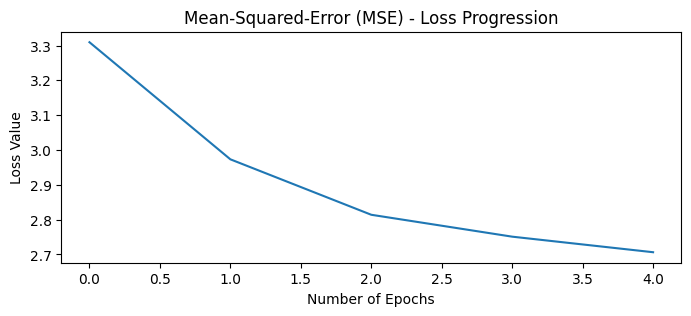

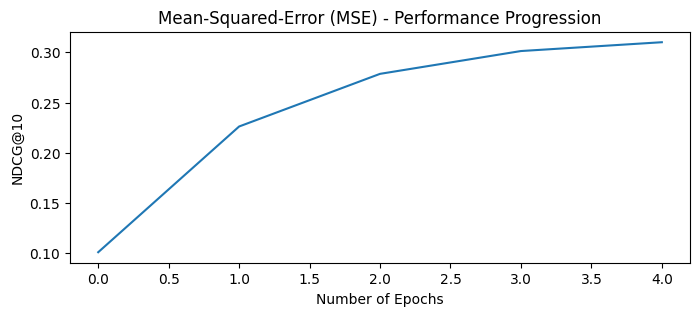

In [ ]:
rng, optimize_rng = jax.random.split(rng)
visualize_output(optimize_loss(MSE_loss_fn, optimize_rng, max_epochs=4, evaluate_every=1),
                 title="Mean-Squared-Error (MSE)")

# 2 Pairwise Learning to Rank
Implement the pairwise loss from the [LambdaLoss paper](https://storage.googleapis.com/pub-tools-public-publication-data/pdf/1e34e05e5e4bf2d12f41eb9ff29ac3da9fdb4de3.pdf):
$$L = \frac{1}{|\{y_{d_i} > y_{d_j}\}|}\sum_{y_{d_i} > y_{d_j}}\log(1 + e^{\hat{y}_{d_j} - \hat{y}_{d_i}}).$$
The $y_{d_i} > y_{d_j}$ indicates that the label of document $i$ is greater than $j$, i.e. $d_i$ is more relevant than $d_j$, and $\sum_{y_{d_i} > y_{d_j}}$ sums over all document pairs with unequal labels.

You may notice that the above formulation is undefined if all documents have the identical labels.
Since any ranking is optimal in this case, we define $L = 0$ in this scenario.
This has some implications on your implementation, since the *mean* function returns *NaN* for empty arrays.

Your implementation needs to be fast enough to be practical, the best way to do this is by using [broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html).

Complete the function below:

In [ ]:
def pairwise_loss_fn(scores, labels, mask):
    padding_mask = jnp.logical_and(mask[:,None], mask[None,:])
    greater_mask = jnp.greater(labels[None,:], labels[:,None])
    combined_mask = jnp.logical_and(padding_mask, greater_mask)
    sum_values = jnp.sum(jnp.log(1 + jnp.exp(scores[:,None]-scores[None,:])),
                       where=combined_mask)
    return sum_values/jnp.maximum(1., jnp.sum(combined_mask))

Here are some test scenarios:

In [ ]:
# checks without masking
assert jnp.isclose(pairwise_loss_fn(jnp.array([1]), jnp.array([0]), jnp.array([True])), 0)
assert jnp.isclose(pairwise_loss_fn(jnp.array([0,0]), jnp.array([0,0]), jnp.array([True, True])), 0)
assert jnp.isclose(pairwise_loss_fn(jnp.array([1,0]), jnp.array([0,1]), jnp.array([True,True])), 1.3132616)
assert jnp.isclose(pairwise_loss_fn(jnp.array([2,-2]), jnp.array([0,1]), jnp.array([True,True])), 4.01815)
assert jnp.isclose(pairwise_loss_fn(jnp.array([2.5,-0.2]), jnp.array([0,1]), jnp.array([True,True])), 2.7650435)
assert jnp.isclose(pairwise_loss_fn(jnp.array([2.5,-0.2]), jnp.array([1,0]), jnp.array([True,True])), 0.06504359)
assert jnp.isclose(pairwise_loss_fn(jnp.array([1,2,3,4,5]), jnp.array([5,1,3,2,4]), jnp.array([True,True,True,True,True])), 1.2749155)
# checks with masking
assert jnp.isclose(pairwise_loss_fn(jnp.array([1,1]), jnp.array([0,1]), jnp.array([True,False])), 0)
assert jnp.isclose(pairwise_loss_fn(jnp.array([0,0,1]), jnp.array([0,0,1]), jnp.array([True, True,False])), 0)
assert jnp.isclose(pairwise_loss_fn(jnp.array([1,0,1]), jnp.array([0,1,1]), jnp.array([True,True,False])), 1.3132616)
assert jnp.isclose(pairwise_loss_fn(jnp.array([2,-2,1]), jnp.array([0,1,1]), jnp.array([True,True,False])), 4.01815)
assert jnp.isclose(pairwise_loss_fn(jnp.array([2.5,-0.2,1]), jnp.array([0,1,1]), jnp.array([True,True,False])), 2.7650435)
assert jnp.isclose(pairwise_loss_fn(jnp.array([2.5,-0.2,1]), jnp.array([1,0,1]), jnp.array([True,True,False])), 0.06504359)
assert jnp.isclose(pairwise_loss_fn(jnp.array([1,2,3,4,5,1]), jnp.array([5,1,3,2,4,1]), jnp.array([True,True,True,True,True,False])), 1.2749155)

Your code should not only be correct, but also fast enough to enable feasible optimization. The following two tests will test how quick your implementation is.

In [ ]:
start_time = time.time()
optimize_loss(pairwise_loss_fn, optimize_rng, max_epochs=1, evaluate_every=1,verbose=False)
seconds_lapsed = time.time() - start_time
print(f'Epoch completed in {seconds_lapsed} seconds, that is {seconds_lapsed - 12:.1f} seconds more than expected.')
assert seconds_lapsed < 20
print(f'Your implementation is fast enough.')

Epoch completed in 13.341245412826538 seconds, that is 1.3 seconds more than expected.
Your implementation is fast enough.


Epoch: 0, Loss: 0.678, NDCG: 0.133
Epoch: 1, Loss: 0.611, NDCG: 0.2971
Epoch: 2, Loss: 0.594, NDCG: 0.3028
Epoch: 3, Loss: 0.590, NDCG: 0.3048
Epoch: 4, Loss: 0.586, NDCG: 0.3157


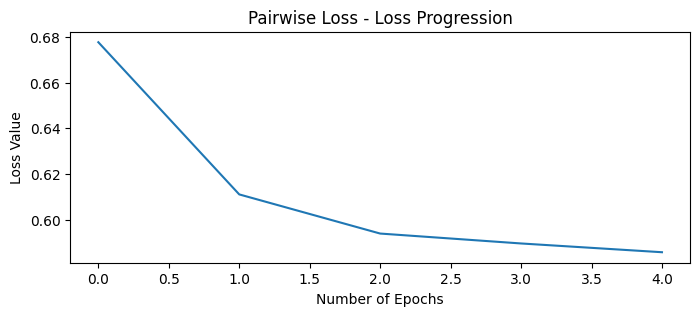

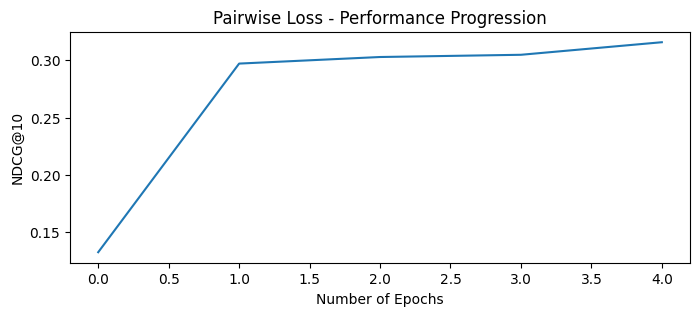

In [ ]:
rng, optimize_rng = jax.random.split(rng)
visualize_output(optimize_loss(pairwise_loss_fn, optimize_rng, max_epochs=4, evaluate_every=1),
                 title="Pairwise Loss")

## Some Tips on Broadcasting

Broadcasting allows one to broadcast a smaller array to a larger shape, this can simulate looping or repetition of data.
For a pairwise loss, this can be useful to create a matrix that contains comparisons of all elements in a vector.

To show you what this can look like consider the following matrix, created by broadcasting two vector and summing them:

In [ ]:
v1 = jnp.arange(5)
v2 = jnp.zeros(5)

In [ ]:
v1[:,None] + v2[None,:]

Array([[0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1.],
       [2., 2., 2., 2., 2.],
       [3., 3., 3., 3., 3.],
       [4., 4., 4., 4., 4.]], dtype=float32)

We can change the direction of broadcasting by adding dimensions in a different place:

In [ ]:
v1[None,:] + v2[:,None]

Array([[0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.]], dtype=float32)

The *None* in the indexing indicates that we wish to add a dimension, the resulting matrix will simply repeat the values in the direction of the new dimension.
The size of the dimension does not matter, it is adjusted contextually.

Broadcasting can be used to avoid looping, for example, we can find all pairs of numbers $x$ and $y$ from zero to five where $x > y$, without a for loop:


In [ ]:
v = jnp.arange(6)
mask = jnp.greater(v[:,None], v[None,:])
mask

Array([[False, False, False, False, False, False],
       [ True, False, False, False, False, False],
       [ True,  True, False, False, False, False],
       [ True,  True,  True, False, False, False],
       [ True,  True,  True,  True, False, False],
       [ True,  True,  True,  True,  True, False]], dtype=bool)

In [ ]:
# the jnp.where function does not work well with jit compilation
# but it allows us to print the example easily
x,y = jnp.where(mask)
for i in range(x.shape[0]):
  print(f'{x[i]} > {y[i]}')

1 > 0
2 > 0
2 > 1
3 > 0
3 > 1
3 > 2
4 > 0
4 > 1
4 > 2
4 > 3
5 > 0
5 > 1
5 > 2
5 > 3
5 > 4


This is a very simple example, but in general, avoiding for loops can greatly increase the execution speed of your code.

# 3 Listwise Learning to Rank

Implement the listwise loss from the [original listwise LTR paper](http://icml2008.cs.helsinki.fi/papers/167.pdf), this paper models the probability of a ranking as a Plackett-Luce model (similar to a soft-max function). As the loss function we will use the negative log-likelihood of the optimal ranking.
Let $R$ denote the optimal ranking for query $q$, ${R[i]}$ as the $i$th document in the optimal ranking and $\hat{y}_{R[i]}$ as its predicted score, the loss is then:
$$L = - \sum_{i = 1}^{|R|} \log\left( \frac{ \exp\left(\hat{y}_{R[i]} \right)}{\sum_{j=i}^{|R|} \exp\left(\hat{y}_{R[j]}\right)} \right).$$

Please note that the denominator sum starts at $i$ and **not** at $1$.

Use broadcasting to make your implementation fast, you probably want to use the *argsort* and *cumsum* functions.
Another trick that makes things easier is using the fact that $\exp(-\infty) = 0$.

Complete the function below:

In [ ]:
def listwise_loss_fn(scores, labels, mask):
#   return 0.
    mask_penalty = jnp.logical_not(mask)*jnp.inf
    best_ranking = jnp.argsort(labels-mask_penalty)[::-1]
    ranked_scores = jnp.exp(scores[best_ranking]-mask_penalty)
    denominator = jnp.cumsum(ranked_scores[::-1])[::-1]
    log_prob = jnp.log(ranked_scores+0.0000001) - jnp.log(denominator+0.0000001)
    return -jnp.sum(log_prob, where=mask)

The following assertions will test the correctness of your implementation in some scenarios.

In [ ]:
# checks without masking
assert jnp.isclose(listwise_loss_fn(jnp.array([1]), jnp.array([0]), jnp.array([True])), 0)
assert jnp.isclose(listwise_loss_fn(jnp.array([1,0]), jnp.array([0,1]), jnp.array([True,True])), 1.3132616)
assert jnp.isclose(listwise_loss_fn(jnp.array([2,-2]), jnp.array([0,1]), jnp.array([True,True])), 4.01815)
assert jnp.isclose(listwise_loss_fn(jnp.array([2.5,-0.2]), jnp.array([0,1]), jnp.array([True,True])), 2.7650435)
assert jnp.isclose(listwise_loss_fn(jnp.array([2.5,-0.2]), jnp.array([1,0]), jnp.array([True,True])), 0.06504359)
assert jnp.isclose(listwise_loss_fn(jnp.array([1,2,3,4,5]), jnp.array([5,1,3,2,4]), jnp.array([True,True,True,True,True])), 6.4266376)
# checks with masking
assert jnp.isclose(listwise_loss_fn(jnp.array([1,1]), jnp.array([0,1]), jnp.array([True,False])), 0)
assert jnp.isclose(listwise_loss_fn(jnp.array([1,0,1]), jnp.array([0,1,1]), jnp.array([True,True,False])), 1.3132616)
assert jnp.isclose(listwise_loss_fn(jnp.array([2,-2,1]), jnp.array([0,1,1]), jnp.array([True,True,False])), 4.01815)
assert jnp.isclose(listwise_loss_fn(jnp.array([2.5,-0.2,1]), jnp.array([0,1,1]), jnp.array([True,True,False])), 2.7650435)
assert jnp.isclose(listwise_loss_fn(jnp.array([2.5,-0.2,1]), jnp.array([1,0,1]), jnp.array([True,True,False])), 0.06504359)
assert jnp.isclose(listwise_loss_fn(jnp.array([1,2,3,4,5,1]), jnp.array([5,1,3,2,4,1]), jnp.array([True,True,True,True,True,False])), 6.4266376)

Your code should not only be correct, but also fast enough to enable feasible optimization. The following two tests will test how quick your implementation is.

In [ ]:
start_time = time.time()
optimize_loss(listwise_loss_fn, optimize_rng, max_epochs=1, evaluate_every=1,verbose=False)
seconds_lapsed = time.time() - start_time
print(f'Epoch completed in {seconds_lapsed} seconds, that is {seconds_lapsed - 12:.1f} seconds more than expected.')
assert seconds_lapsed < 20
print(f'Your implementation is fast enough.')

Epoch completed in 12.76579475402832 seconds, that is 0.8 seconds more than expected.
Your implementation is fast enough.


Epoch: 0, Loss: 456.188, NDCG: 0.092
Epoch: 1, Loss: 437.496, NDCG: 0.2839
Epoch: 2, Loss: 436.213, NDCG: 0.2911
Epoch: 3, Loss: 435.835, NDCG: 0.2991
Epoch: 4, Loss: 435.517, NDCG: 0.2981


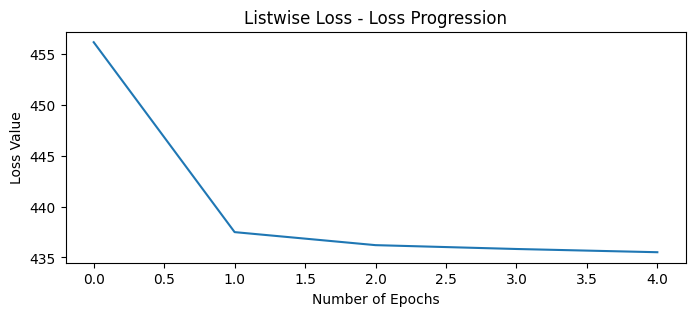

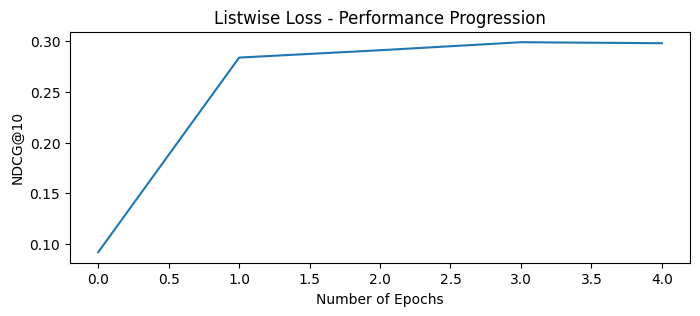

In [ ]:
rng, optimize_rng = jax.random.split(rng)
visualize_output(optimize_loss(listwise_loss_fn, optimize_rng,
                learning_rate=0.01, max_epochs=4, evaluate_every=1),
                 title="Listwise Loss")

If you run into a *NaN* loss, this could be because of underflow causing the computation of $log(0)$ which is undefined. A simple solution for this issue is to add a very small positive number to the log input, i.e. $10^{-6}$.

#4 Approximate DCG Loss

Finally, implement the ApproxDCG loss based on the approximation described by the [Rax paper](https://research.google/pubs/rax-composable-learning-to-rank-using-jax/).
The idea is that the rank of a document can be approximated by a pairwise summing:
$$
\text{rank}(d_i)= 1 + \sum_{j: j\not=i} \mathbb{1}[s_i > s_j] \approx  1 + \sum_{j:i\not=j} \frac{1}{1 + \exp(s_j - s_i)} = \overline{\text{rank}}(d_i).
$$
In turn, this approximate rank can be used to approximate a metric like DCG, resulting in the loss:
$$
L = -\sum_{d} \frac{\text{label}(d)}{log_2(1 + \overline{\text{rank}}(d))}.
$$
Implement this approximage DCG loss.

In [ ]:
def approx_dcg_loss_fn(scores, labels, mask):
#   return 0.
    mask_penalty = jnp.logical_not(mask)*jnp.inf
    # mask_penalty
    rank = 1/(1+jnp.exp(scores[:, None] - scores[None, :]-mask_penalty))
    rankd = jnp.sum(rank, axis=1, where=mask)
    loss = -jnp.sum(labels / jnp.log2(1.5 + rankd), where=mask)
    return loss

The following checks will verify if your code is correct in test scenarios:

In [ ]:
# checks without masking
assert jnp.isclose(approx_dcg_loss_fn(jnp.array([1]), jnp.array([0]), jnp.array([True])), 0)
assert jnp.isclose(approx_dcg_loss_fn(jnp.array([10,0]), jnp.array([0,1]), jnp.array([True,True])), -0.6309385)
assert jnp.isclose(approx_dcg_loss_fn(jnp.array([20,-20]), jnp.array([0,1]), jnp.array([True,True])), -0.63092977)
assert jnp.isclose(approx_dcg_loss_fn(jnp.array([2.5,2]), jnp.array([0,1]), jnp.array([True,True])), -0.7189484)
assert jnp.isclose(approx_dcg_loss_fn(jnp.array([2.5,2]), jnp.array([1,0]), jnp.array([True,True])), -0.80033934)
assert jnp.isclose(approx_dcg_loss_fn(jnp.array([10,20,30,40,50]), jnp.array([5,1,3,2,4]), jnp.array([True,True,True,True,True])), -9.1266775)
# checks with masking
assert jnp.isclose(approx_dcg_loss_fn(jnp.array([1,1]), jnp.array([0,1]), jnp.array([True,False])), 0)
assert jnp.isclose(approx_dcg_loss_fn(jnp.array([10,0,1]), jnp.array([0,1,1]), jnp.array([True,True,False])), -0.6309385)
assert jnp.isclose(approx_dcg_loss_fn(jnp.array([20,-20,1]), jnp.array([0,1,1]), jnp.array([True,True,False])), -0.63092977)
assert jnp.isclose(approx_dcg_loss_fn(jnp.array([2.5,2,1]), jnp.array([0,1,1]), jnp.array([True,True,False])), -0.7189484)
assert jnp.isclose(approx_dcg_loss_fn(jnp.array([2.5,2,1]), jnp.array([1,0,1]), jnp.array([True,True,False])), -0.80033934)
assert jnp.isclose(approx_dcg_loss_fn(jnp.array([10,20,30,40,50,1]), jnp.array([5,1,3,2,4,1]), jnp.array([True,True,True,True,True,False])), -9.1266775)

The following code checks if your implementation is computationally efficient enough and works with jit compilation.

In [ ]:
start_time = time.time()
optimize_loss(approx_dcg_loss_fn, optimize_rng, max_epochs=1, evaluate_every=1,verbose=False)
seconds_lapsed = time.time() - start_time
print(f'Epoch completed in {seconds_lapsed} seconds, that is {seconds_lapsed - 12:.1f} seconds more than expected.')
assert seconds_lapsed < 20
print(f'Your implementation is fast enough.')

Epoch completed in 13.949991464614868 seconds, that is 1.9 seconds more than expected.
Your implementation is fast enough.


Epoch: 0, Loss: -17.407, NDCG: 0.116
Epoch: 1, Loss: -21.098, NDCG: 0.2826
Epoch: 2, Loss: -23.977, NDCG: 0.3214
Epoch: 3, Loss: -24.722, NDCG: 0.3316
Epoch: 4, Loss: -25.049, NDCG: 0.3360


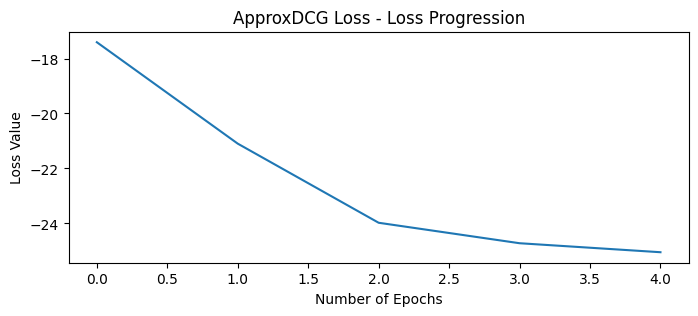

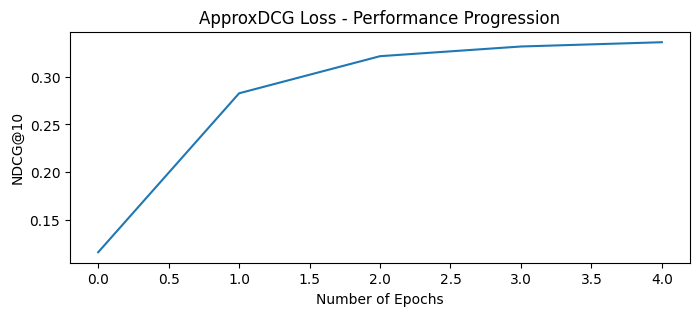

In [ ]:
rng, optimize_rng = jax.random.split(rng)
visualize_output(optimize_loss(approx_dcg_loss_fn, optimize_rng,
                learning_rate=0.01, max_epochs=4, evaluate_every=1),
                 title="ApproxDCG Loss")

# 5 Full Training Comparison

Now that you have finished your implementations, we can do a longer run to compare the learning curves of the different loss functions.
The following should take about 15 minutes to run, feel free to have a break while it runs.

In [ ]:
losses = {
    "Mean-Squared-Error (MSE)": MSE_loss_fn,
    "Pairwise Loss": pairwise_loss_fn,
    "Listwise Loss": listwise_loss_fn,
    "ApproxDCG Loss": approx_dcg_loss_fn,
          }
result = {}
for name, loss in losses.items():
  rng, optimize_rng = jax.random.split(rng)
  print(f'Optimizing {name}.')
  result[name] = optimize_loss(loss, optimize_rng, max_epochs=15, evaluate_every=1, verbose=False)

Optimizing Mean-Squared-Error (MSE).
Optimizing Pairwise Loss.
Optimizing Listwise Loss.
Optimizing ApproxDCG Loss.


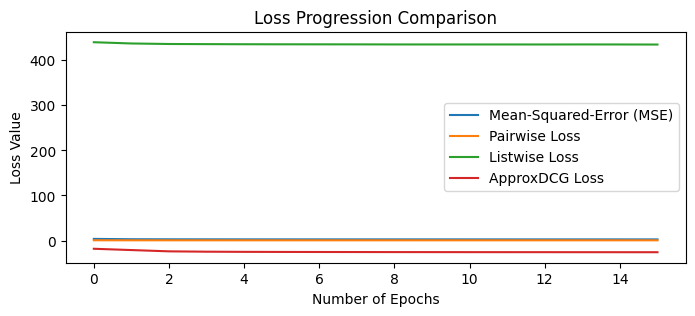

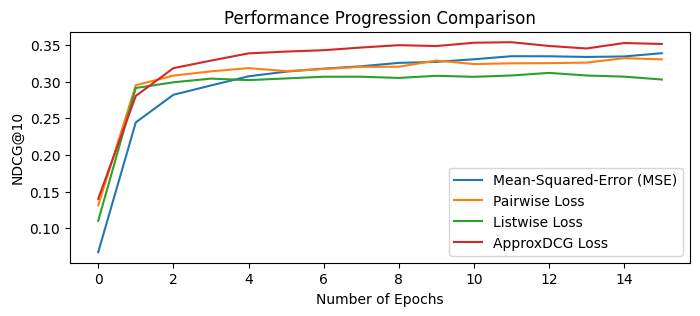

In [ ]:
plt.title('Loss Progression Comparison')
for name, output_list in result.items():
  plt.plot([x[0] for x in output_list if len(x) > 1],
           [x[1] for x in output_list if len(x) > 1],
           label=name)
plt.xlabel('Number of Epochs')
plt.ylabel('Loss Value')
plt.legend()
plt.show()
plt.close()

plt.title('Performance Progression Comparison')
for name, output_list in result.items():
  plt.plot([x[0] for x in output_list if len(x) > 2],
          [x[2] for x in output_list if len(x) > 2],
          label=name)
plt.xlabel('Number of Epochs')
plt.ylabel('NDCG@10')
plt.legend()
plt.show()
plt.close()

# 6 Reflection

Look and compare the loss and DCG plots for the different LTR methods.
Discuss the differences you see and how this relates to the LTR theory.

\[Keep you answer limited to 500 words.\]